In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-01-29 08:55:56.865467: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 08:55:57.496902: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-29 08:55:57.496984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-29 08:55:57.496993: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
# load data
data_path = '/home/hpinkard_waller/data/DINO_debugging'
background = 50
photons_per_pixel = 400
patch_size = 39
sample = '2_plane_lung_uniform_patches'

single_lens_data = np.load(os.path.join(data_path, '2_plane_lung_single_lens.npy'))
double_lens_data = np.load(os.path.join(data_path, '2_plane_lung_double_lens.npy'))
many_lens_data = np.load(os.path.join(data_path, '2_plane_lung_many_lens.npy'))

single_lens_data = single_lens_data / single_lens_data.mean() * photons_per_pixel
double_lens_data = double_lens_data / double_lens_data.mean() * photons_per_pixel
many_lens_data = many_lens_data / many_lens_data.mean() * photons_per_pixel

single_lens_data += background
double_lens_data += background
many_lens_data += background

data_min = min(single_lens_data.min(), double_lens_data.min(), many_lens_data.min())
data_max = max(single_lens_data.max(), double_lens_data.max(), many_lens_data.max())

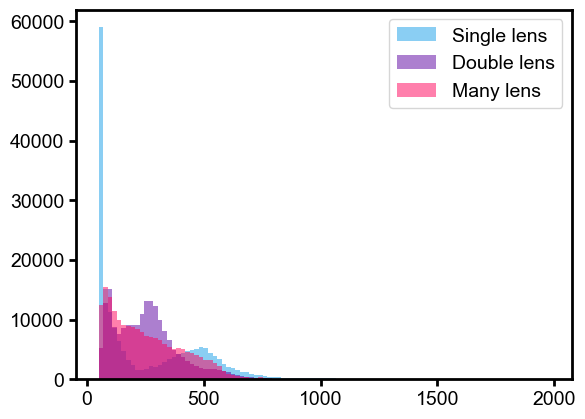

In [ ]:
# plot histograms
fig, ax = plt.subplots()
hist_max = max(np.percentile(single_lens_data, 99.5), np.percentile(double_lens_data, 99.5), np.percentile(many_lens_data, 99.5))

bins = np.linspace(data_min, data_max, 100)
_ = ax.hist(single_lens_data[:8].ravel(), bins=bins, label='Single lens', alpha=0.5)
_ = ax.hist(double_lens_data[:8].ravel(), bins=bins, label='Double lens', alpha=0.5)
_ = ax.hist(many_lens_data[:8].ravel(), bins=bins, label='Many lens', alpha=0.5)
ax.legend()

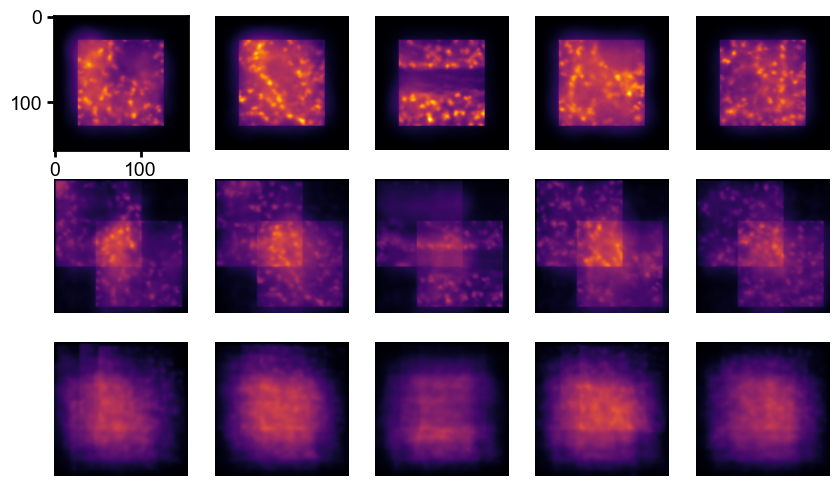

In [3]:
vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


fig, axs = plt.subplots(3, 5, figsize=(10, 6))

for i in range(5):
    axs[0, i].imshow(single_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[1, i].imshow(double_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[2, i].imshow(many_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    if i != 0:
        axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

In [5]:
print(double_lens_patches.mean(), single_lens_patches.mean())

452.07117 447.19925


100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


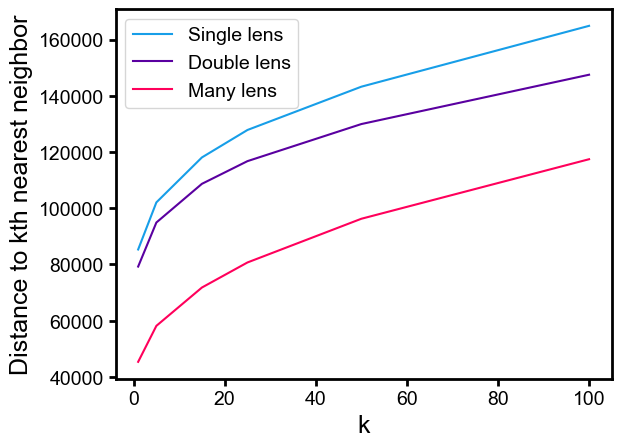

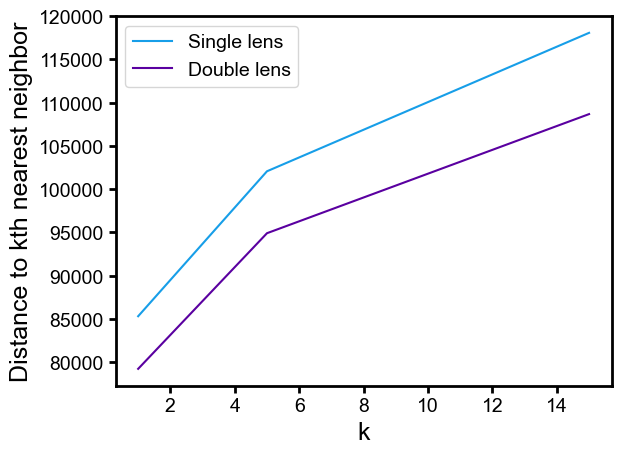

: 

In [6]:
def extract_uniform_patches(data, patch_size, num_patches, verbose=False):
    """
    Extract patches from data with uniform random sampling
    """
    image_shape = data.shape[1:]
    if image_shape[0] % patch_size != 0 or image_shape[1] % patch_size != 0:
        raise ValueError('Patch size must evenly divide image size')
    num_blocks = image_shape[0] // patch_size
    blocks = []
    for i in range(num_blocks):
        for j in range(num_blocks):
            block = data[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            blocks.append(block)
    blocks = np.concatenate(blocks, axis=0)
    # take a random subset of them as patches
    indices = onp.random.choice(blocks.shape[0], num_patches, replace=False)
    return blocks[indices]

# Try nearest neighbor distance
from encoding_information.information_estimation import *

single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

# # normalize photons per pixel
# single_lens_patches = single_lens_patches / single_lens_patches.mean() * photons_per_pixel
# double_lens_patches = double_lens_patches / double_lens_patches.mean() * photons_per_pixel
# many_lens_patches = many_lens_patches / many_lens_patches.mean() * photons_per_pixel

@partial(jit, static_argnums=1)
def nearest_neighbors_distance(X, k):
    """
    Compute the distance to the kth nearest neighbor for each point in X by
    exhaustively searching all points in X.
    
    X : ndarray, shape (n_samples, W, H) or (n_samples, num_features)
    k : int
    """
    X = X.reshape(X.shape[0], -1)
    distance_matrix = np.sum((X[:, None, :] - X[None, :, :]) ** 2, axis=-1)
    kth_nn_index = np.argsort(distance_matrix, axis=-1)[:, k]
    kth_nn = X[kth_nn_index, :]
    kth_nn_dist = np.sum(np.abs(X - kth_nn), axis=-1)
    # kth_nn_dist = np.sqrt(np.sum((X - kth_nn)**2, axis=-1))
    return kth_nn_dist


single_lens_distances = []
double_lens_distances = []
many_lens_distances = []
ks = [1, 5, 15, 25, 50, 100]
for k in tqdm(ks):
    single_lens_distances.append(nearest_neighbors_distance(single_lens_patches, k).mean())
    double_lens_distances.append(nearest_neighbors_distance(double_lens_patches, k).mean())
    many_lens_distances.append(nearest_neighbors_distance(many_lens_patches, k).mean())

fig, ax = plt.subplots()
ax.plot(ks, single_lens_distances, label='Single lens')
ax.plot(ks, double_lens_distances, label='Double lens')
ax.plot(ks, many_lens_distances, label='Many lens')
ax.set_xlabel('k')
ax.set_ylabel('Distance to kth nearest neighbor')
ax.legend()

fig, ax = plt.subplots()
ax.plot(ks[:3], single_lens_distances[:3], label='Single lens')
ax.plot(ks[:3], double_lens_distances[:3], label='Double lens')
# ax.plot(ks, many_lens_distances[:3], label='Many lens')
ax.set_xlabel('k')
ax.set_ylabel('Distance to kth nearest neighbor')
ax.legend()